In [2]:
import pandas as pd
import sqlite3
import numpy as np

# Connect to the database
with sqlite3.connect('point_clouds_pressure_stratified_normalized.db') as conn:
    cursor = conn.cursor()
    cursor.execute("SELECT id, data FROM point_clouds")
    rows = cursor.fetchall()

# Convert the data to a pandas DataFrame
data_list = []
for id_, binary_data in rows:
    points = np.frombuffer(binary_data, dtype=np.float32).reshape(8192, 4)
    data_list.append({
        'id': id_,
        'points': points
    })

df = pd.DataFrame(data_list)

In [4]:
df.head()

,id,points
0,E_S_WWC_WM_019,"[[0.20626685, 0.82736623, 0.0, 0.7464077], [0...."
1,E_S_WWC_WM_025,"[[0.20892283, 0.077970386, 0.0, 0.74078673], [..."
2,E_S_WWC_WM_031,"[[0.21205334, 0.8026639, 0.0021923066, 0.75477..."
3,E_S_WWC_WM_582,"[[0.20431383, 0.87083393, 0.004990345, 0.74841..."
4,E_S_WWC_WM_596,"[[0.21041545, 0.84471196, 0.0, 0.7489939], [0...."


In [5]:
# Print column info
print("DataFrame Info:")
print("-" * 50)
print(f"Number of rows: {len(df)}")
print("\nColumn details:")
for col in df.columns:
    print(f"\n{col}:")
    print(f"Type: {df[col].dtype}")
    if col == 'points':
        # Get shape of first points array to represent the structure
        print(f"Points array shape: {df[col].iloc[0].shape}")


DataFrame Info:
--------------------------------------------------
Number of rows: 8129

Column details:

id:
Type: object

points:
Type: object
Points array shape: (8192, 4)



Pressure values statistics:
Min pressure: 0.7400221
Max pressure: 0.8137559
Mean pressure: 0.7943727


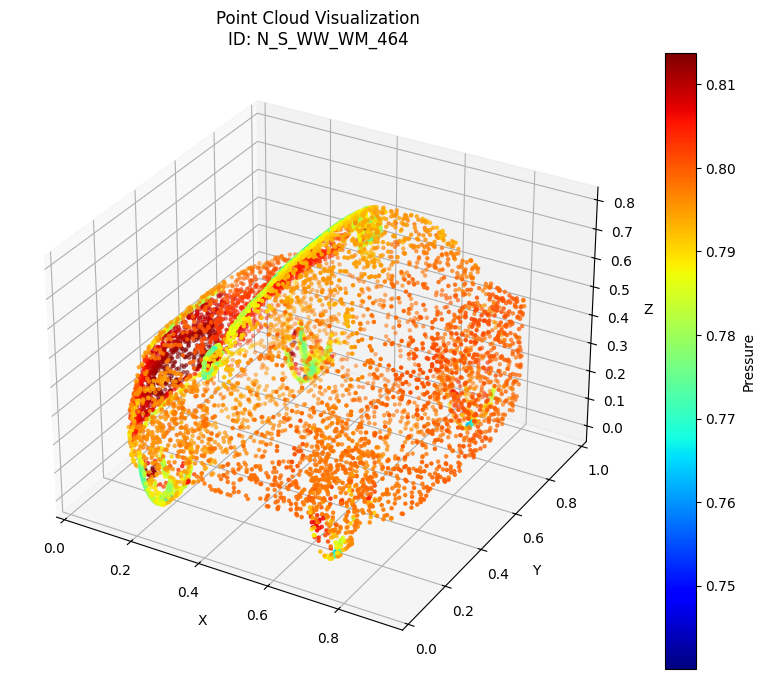

In [27]:
# Choose a random row and get the point cloud data
random_row = df.sample(n=1).iloc[0]
points = random_row['points']

# Create 3D scatter plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot points colored by pressure
scatter = ax.scatter(points[:,0], points[:,1], points[:,2], 
                    c=points[:,3], cmap='jet',
                    s=5) # Increased point size for better visibility

# Add a colorbar
plt.colorbar(scatter, label='Pressure')

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y') 
ax.set_zlabel('Z')
ax.set_title(f'Point Cloud Visualization\nID: {random_row["id"]}')

# Print statistics
print("\nPressure values statistics:")
print("Min pressure:", points[:,3].min())
print("Max pressure:", points[:,3].max()) 
print("Mean pressure:", points[:,3].mean())

plt.show()


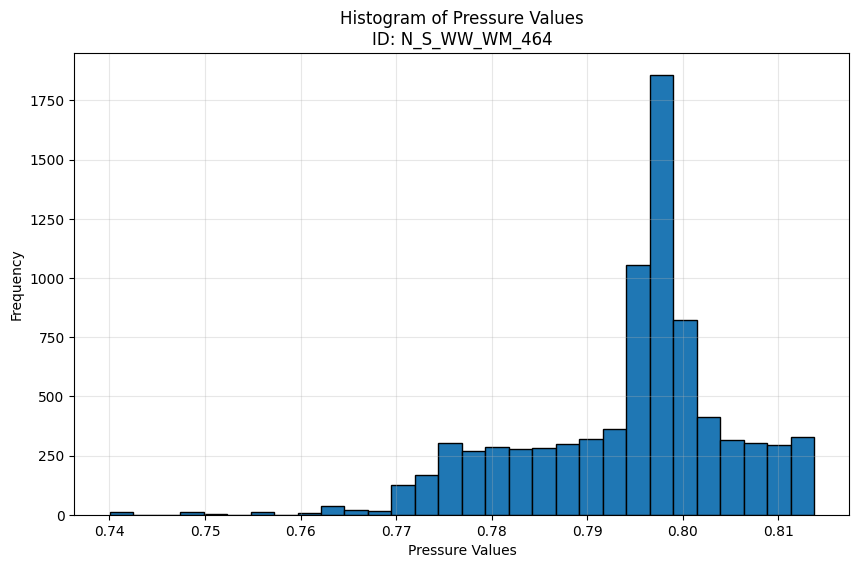

In [29]:
# Create histogram of pressure values from the random point cloud
plt.figure(figsize=(10, 6))
plt.hist(points[:,3], bins=30, edgecolor='black')
plt.xlabel('Pressure Values')
plt.ylabel('Frequency')
plt.title(f'Histogram of Pressure Values\nID: {random_row["id"]}')
plt.grid(True, alpha=0.3)
plt.show()


Processing point clouds: 100%|██████████| 8129/8129 [08:24<00:00, 16.10it/s]  


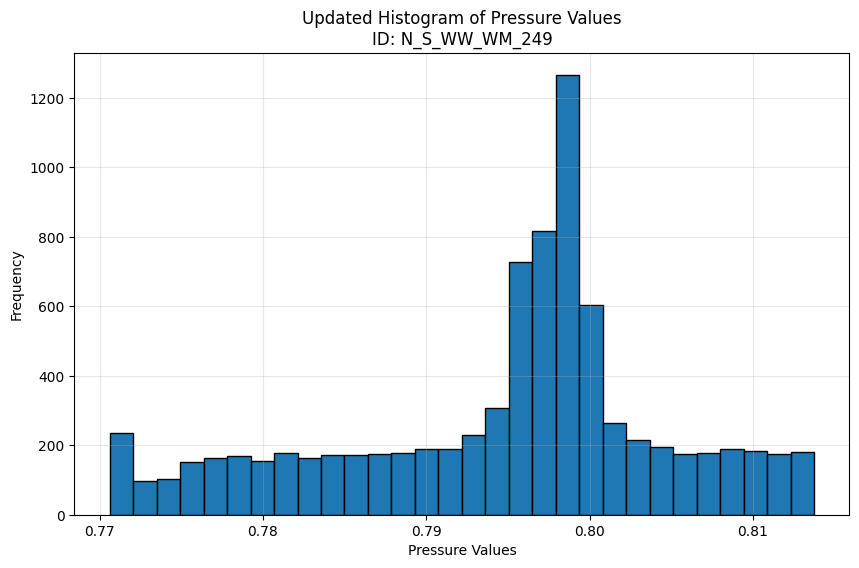

In [37]:
import tqdm

# Create a new DataFrame to store updated point clouds
updated_df = pd.DataFrame(columns=['id', 'points'])

# Loop through all point clouds in the original DataFrame with progress bar
for idx, row in tqdm.tqdm(df.iterrows(), total=len(df), desc="Processing point clouds"):
    points = np.array(row['points'])
    
    # Get histogram data for this point cloud
    hist_values, bin_edges = np.histogram(points[:,3], bins=30)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Find bins with frequency >= 100
    valid_bins = bin_centers[hist_values >= 100]

    if len(valid_bins) > 0:
        # Create a copy of points to store updated values
        updated_points = points.copy()
        
        # For each point, if it falls in a low-frequency bin,
        # update its pressure to nearest high-frequency bin
        for i in range(len(updated_points)):
            pressure = updated_points[i,3]
            # Find which bin this pressure falls into
            bin_idx = np.digitize(pressure, bin_edges) - 1
            if bin_idx < len(hist_values) and hist_values[bin_idx] < 100:
                # Find nearest valid bin
                nearest_valid_bin = valid_bins[np.abs(valid_bins - pressure).argmin()]
                updated_points[i,3] = nearest_valid_bin

        # Add updated point cloud to new DataFrame
        updated_df.loc[len(updated_df)] = [row['id'], updated_points.tolist()]
    else:
        print(f"No bins found with frequency >= 100 for ID: {row['id']}")
        # Add original point cloud to new DataFrame if no updates needed
        updated_df.loc[len(updated_df)] = [row['id'], points.tolist()]

# Plot histogram of last processed point cloud as an example
plt.figure(figsize=(10, 6))
plt.hist(updated_points[:,3], bins=30, edgecolor='black')
plt.xlabel('Pressure Values')
plt.ylabel('Frequency')
plt.title(f'Updated Histogram of Pressure Values\nID: {row["id"]}')
plt.grid(True, alpha=0.3)
plt.show()

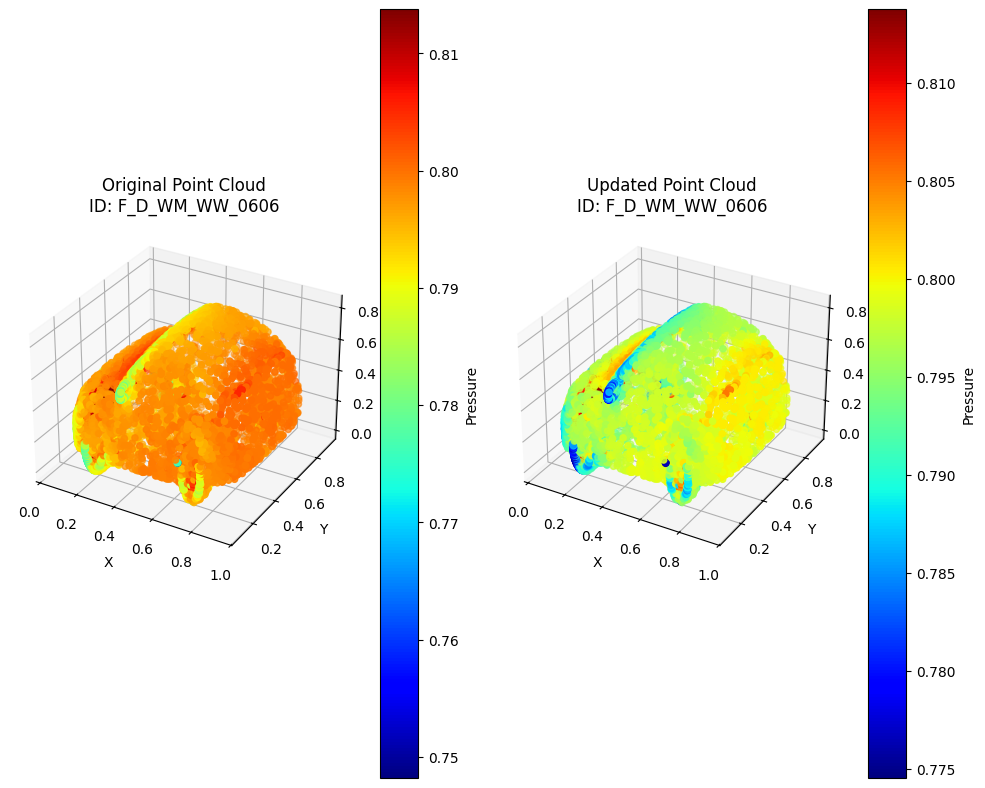

In [39]:
# Randomly select an ID from the original DataFrame
random_id = df['id'].sample().iloc[0]

# Get the corresponding rows from original and updated DataFrames
original_points = np.array(df[df['id'] == random_id]['points'].iloc[0])
updated_points = np.array(updated_df[updated_df['id'] == random_id]['points'].iloc[0])

# Create side-by-side 3D scatter plots to compare original and updated point clouds
fig = plt.figure(figsize=(10, 8))

# Original point cloud
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(original_points[:,0], original_points[:,1], original_points[:,2], 
                      c=original_points[:,3], cmap='jet')
ax1.set_title(f'Original Point Cloud\nID: {random_id}')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
fig.colorbar(scatter1, ax=ax1, label='Pressure')

# Updated point cloud
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(updated_points[:,0], updated_points[:,1], updated_points[:,2],
                      c=updated_points[:,3], cmap='jet')
ax2.set_title(f'Updated Point Cloud\nID: {random_id}')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
fig.colorbar(scatter2, ax=ax2, label='Pressure')

plt.tight_layout()
plt.show()


In [42]:
# Create new database with updated point clouds
output_db_path = "updated_point_clouds.db"
print("Creating new database with updated point clouds...")

with sqlite3.connect(output_db_path) as out_conn:
    out_cursor = out_conn.cursor()
    
    # Create the new table with TEXT id
    out_cursor.execute("""
        CREATE TABLE point_clouds (
            id TEXT PRIMARY KEY,
            data BLOB NOT NULL
        )
    """)
    
    # Process and save each updated point cloud
    for _, row in tqdm.tqdm(updated_df.iterrows(), total=len(updated_df)):
        # Get points array and convert to float32
        points = np.array(row['points'], dtype=np.float32)
        
        # Convert to binary blob
        binary_data = points.tobytes()
        
        try:
            out_cursor.execute("INSERT INTO point_clouds (id, data) VALUES (?, ?)",
                             (row['id'], binary_data))
        except sqlite3.Error as e:
            print(f"Error inserting record {row['id']}: {e}")
            continue
    
    out_conn.commit()

print(f"Updated point clouds database saved to: {output_db_path}")
print(f"Data shape per point cloud: {points.shape}")


Creating new database with updated point clouds...


100%|██████████| 8129/8129 [01:24<00:00, 95.86it/s] 


Updated point clouds database saved to: updated_point_clouds.db
Data shape per point cloud: (8192, 4)
